In [46]:
import pandas
import networkx as nx
import sqlite3

Trabajamos para una discógráfica importante; nuestra misión corporativa es <strike><a href="https://en.wikipedia.org/wiki/Rent-seeking">rent-seeking</a></strike> proteger derechos de autor.

Nuestros [colaboradores](https://en.wikipedia.org/wiki/Unofficial_collaborator) en distintas ciudades nos mandan informes de cuándo escuchan una canción por la calle. También disponemos de una base de datos interna que asocia canciones a identificadores [iswc](https://en.wikipedia.org/wiki/International_Standard_Musical_Work_Code).

Necesitamos combinar los reportes de campo con nuestra base de datos interna vía [data fusion](https://en.wikipedia.org/wiki/Data_fusion) para poder obtener un conjunto de datos desduplicado.

* [Los datos](#los-datos)
    * [reference.csv](#reference)
    * [field_reports.csv](#field-reports)
* [El resultado](#el-resultado)
* [El algoritmo](#el-algoritmo)
    * [Construir el grafo](#construir-el-grafo)
    * [Usar el grafo](#usar-el-grafo)
* [Optimizar el algoritmo](#optimizar-el-algoritmo)

### Los datos<a class="anchor" id="los-datos"></a>

El campo `participants` contiene un conjunto de valores separado por el caracter `|`.

#### reference.csv<a class="anchor" id="reference"></a>

[reference.csv](reference.csv) asocia canciones a identificadores [iswc](https://en.wikipedia.org/wiki/International_Standard_Musical_Work_Code); una canción puede tener varios identificadores distintos.

In [47]:
reference = pandas.read_csv('reference.csv')
reference

,id,iswc,title,participants
0,0,T-800.802.619-6,Du Hast,kruspe
1,1,T-800.802.619-6,Du Hast,kruspe|lindemann
2,2,T-800.125.458-7,Bück dich,kruspe|lindemann
3,3,T-071.081.651-5,Dope Man,Ice Cube|Dr. Dre
4,4,T-070.044.219-8,Dope Man,Ice Cube
5,5,T-070.006.587-7,Another Day,Dream Theater|Jordan Rudess
6,6,T-010.445.085-2,Another Day,Paul McCartney


#### field_reports.csv<a class="anchor" id="field-reports"></a>

Field reports asocia títulos de canciones y participantes a sitios donde se ha escuchado esa canción; los trabajadores de campo no se saben los iswcs así que apuntan el título y los artistas que recuerdan.

In [48]:
field_reports = pandas.read_csv('field_reports.csv')
field_reports

,id,title,participants,place
0,0,Another Day,Dream Theater,valencia
1,1,Du Hast,kruspe,berlin
2,2,Bück dich,kruspe|lindemann|landers,berlin
3,3,Dope Man,Ice Cube|Dr. Dre,massalfassar
4,4,Space Oddity,Bowie,valencia
5,5,Dope Man,Ice Cube|Dr. Dre,valencia


### El resultado<a class="anchor" id="el-resultado"></a>

Queremos combinar estos csvs para generar una tabla desduplicada con los siguientes campos, con una fila por canción:

* **title**: el título de la canción
* **iswcs**: todos los iswc asociados a esta canción, separados por `|`
* **places**: todas las ciudades donde se ha escuchado esta canción según los reportes de campo, separados por `|`
* **participants**: todos los participantes asociados a esta canción, separados por `|`

### El algoritmo<a class="anchor" id="el-algoritmo"></a>

Para desduplicar las filas podemos usar las siguientes relaciones:

* si 2 canciones tienen el mismo iswc, consideramos que son la misma canción
* si 2 canciones tienen el mismo `title` y comparten al menos 1 `participant`, consideramos que son la misma canción

Nuestro data scientist ha desarrollado un algoritmo (lento) que agrupa las filas para encontrar las canciones de la siguiente manera:

1. construye un grafo donde los nodos son las filas de los conjuntos de datos de `reference.csv` y `field_reports.csv`
2. conecta los nodos que tienen la relación 1 (iswc igual) con edges no dirigidas
3. conecta los nodos que tienen la relación 2 (title y al menos 1 colaborador compartido) con edges no dirigidas
4. encuentra las [componentes conexas](https://en.wikipedia.org/wiki/Component_(graph_theory)) de este grafo: cada componente conexa es una canción

#### Construir el grafo<a class="anchor" id="construir-el-grafo"></a>

In [49]:
def split_participants(participants):
    return set(participants.split('|'))

def create_db(conn):
    conn.execute("""
        create table nodes(
            id text not null, 
            iswc text, 
            title text not null, 
            participants text,
            place text
        );
    """)
    conn.execute("""
        create view nodes_view as
        select * from nodes
    """)


def get_key_from_dbid(dbid: str):
    key1, key2 = dbid.split("|")
    return (key1, int(key2))



def load_reference(g, df, conn):
    cur = conn.cursor()
    for r in df.to_dict(orient="records"):
        key = ('reference.csv', r['id'])
        g.add_node(key,
            id=r['id'],
            iswc=r['iswc'],
            title=r['title'],
            participants=split_participants(r['participants'])
        )
        cur.execute("insert into nodes values (?, ?, ?, ?, ?)", ("{0}|{1}".format(key[0], key[1]), r['iswc'], r['title'], r['participants'], None))
    conn.commit()


def load_field_reports(g, df, conn):
    cur = conn.cursor()
    for r in df.to_dict(orient="records"):
        key = ('field_reports.csv', r['id'])
        g.add_node(key,
            id=r['id'],
            title=r['title'],
            participants=split_participants(r['participants']),
            place=r['place']
        )
        cur.execute("insert into nodes values (?, ?, ?, ?, ?)", ("{0}|{1}".format(key[0], key[1]), None, r['title'], r['participants'], r['place']))
    conn.commit()

        
def add_iswc_edges(g, conn):
    cur = conn.cursor()
    cur.execute("""
    SELECT nodes.id as n_id,
	    nodes_view.id as m_id
    FROM nodes
    CROSS JOIN nodes_view 
    WHERE nodes.iswc == nodes_view.iswc and nodes.id != nodes_view.id;
    """)
    for row in cur:
        g.add_edge(get_key_from_dbid(row[0]), get_key_from_dbid(row[1]))

                    
def add_title_participant_edges(g):
    # el coste de este algoritmo es O(n^2) en el número n de nodos del grafo
    for n in g.nodes:
        for m in g.nodes:
            if n != m and g.nodes[n]['title'] == g.nodes[m]['title']:
                shared_participants = g.nodes[n]['participants'].intersection(g.nodes[m]['participants'])
                if len(shared_participants) > 0:
                    print("edge({0}, {1})".format(n, m))
                    g.add_edge(n, m)
                    
    """
    SELECT nodes.id as n_id,
	    nodes_view.id as m_id
    FROM nodes
    CROSS JOIN nodes_view 
    WHERE nodes.id != nodes_view.id and nodes.title == nodes_view.title;
    """    
                    

#### Usar el grafo<a class="anchor" id="usar-el-grafo"></a>

Una vez disponemos del grafo con todos los datos y edges cargados, podemos extraer las canciones identificando las componentes conexas y fusionando apropiadamente los datos de todas las filas de una componente nos dará el output deseado:

In [50]:
def component_to_song(c, g):
    titles = set()
    iswcs = set()
    places = set()
    participants = set()

    for key in c:
        node = g.nodes[key]
        titles.add(node['title'])
        
        iswc = node.get('iswc')
        if iswc:
            iswcs.add(iswc)
            
        place = node.get('place')
        if place:
            places.add(place)
            
        participants = participants.union(node['participants'])

    if len(titles) > 1:
        raise Exception("A song with multiple titles contradicts our assumptions")

    return dict(
        iswcs='|'.join(iswcs),
        title=list(titles)[0],
        places='|'.join(places),
        participants='|'.join(participants),
    )

def extract_songs(g):
    records = [component_to_song(c, g) for c in nx.algorithms.components.connected_components(g)]    
    return pandas.DataFrame.from_records(records, columns=['title', 'iswcs', 'places', 'participants'])
        

edge(('reference.csv', 0), ('reference.csv', 1))
edge(('reference.csv', 0), ('field_reports.csv', 1))
edge(('reference.csv', 1), ('reference.csv', 0))
edge(('reference.csv', 1), ('field_reports.csv', 1))
edge(('reference.csv', 2), ('field_reports.csv', 2))
edge(('reference.csv', 3), ('reference.csv', 4))
edge(('reference.csv', 3), ('field_reports.csv', 3))
edge(('reference.csv', 3), ('field_reports.csv', 5))
edge(('reference.csv', 4), ('reference.csv', 3))
edge(('reference.csv', 4), ('field_reports.csv', 3))
edge(('reference.csv', 4), ('field_reports.csv', 5))
edge(('reference.csv', 5), ('field_reports.csv', 0))
edge(('field_reports.csv', 0), ('reference.csv', 5))
edge(('field_reports.csv', 1), ('reference.csv', 0))
edge(('field_reports.csv', 1), ('reference.csv', 1))
edge(('field_reports.csv', 2), ('reference.csv', 2))
edge(('field_reports.csv', 3), ('reference.csv', 3))
edge(('field_reports.csv', 3), ('reference.csv', 4))
edge(('field_reports.csv', 3), ('field_reports.csv', 5))
edge(

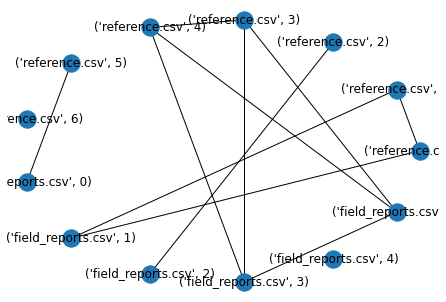

In [51]:
#conn = sqlite3.connect(":memory:")
conn = sqlite3.connect("nodes.db")

# create graph, load node data
g = nx.Graph()
create_db(conn)
load_reference(g, reference, conn)
load_field_reports(g, field_reports, conn)

# add relationship edges
add_iswc_edges(g, conn)
add_title_participant_edges(g)

conn.close()

# visualize graph
nx.draw_circular(g, with_labels=True)

In [52]:
# use graph to fuse data
fused_data = extract_songs(g)
fused_data

,title,iswcs,places,participants
0,Du Hast,T-800.802.619-6,berlin,kruspe|lindemann
1,Bück dich,T-800.125.458-7,berlin,kruspe|lindemann|landers
2,Dope Man,T-071.081.651-5|T-070.044.219-8,massalfassar|valencia,Ice Cube|Dr. Dre
3,Another Day,T-070.006.587-7,valencia,Jordan Rudess|Dream Theater
4,Another Day,T-010.445.085-2,,Paul McCartney
5,Space Oddity,,valencia,Bowie


### Optimizar el algoritmo<a class="anchor" id="optimizar-el-algoritmo"></a>

El algoritmo funciona bien pero es lento: si tenemos n filas en total combinando `reference.csv` y `field_reports.csv`,
el [coste del algoritmo](https://en.wikipedia.org/wiki/Big_O_notation) será del orden $O(n^2)$, ya que lleva a cabo comparaciones entre todos los nodos del grafo para determinar si existen relaciones entre ellos.

Para nuestros csvs de juguete no es un problema, pero si tuviésemos csvs con millones de canciones sería otro cantar.

#### 1 

**Encuentra un algoritmo más rápido que obtenga el mismo resultado**.

¿Puedes cambiar el algoritmo para que sea más eficiente? Da igual que uses networkx, o python puro, u otra cosa.

#### 2 

El tiempo de ejecución del algoritmo del data scientist depende del número total de filas en `reference.csv` y `field_reports.csv`: si hay `n` filas en total, el tiempo de ejecución será del órden $O(n^2)$

¿De qué depende el tiempo de ejecución de tu algoritmo?

	Du Hast	T-800.802.619-6	berlin	lindemann|kruspe
1	Bück dich	T-800.125.458-7	berlin	lindemann|landers|kruspe
2	Dope Man	T-070.044.219-8|T-071.081.651-5	massalfassar|valencia	Ice Cube|Dr. Dre
3	Another Day	T-070.006.587-7	valencia	Dream Theater|Jordan Rudess
4	Another Day	T-010.445.085-2		Paul McCartney
5	Space Oddity		valencia	Bowie